In [1]:
from tools import HopfieldNetwork
import numpy as np

# 3.5 Capacity

## 3.5.1 Capacity Stress Testing

### How many patterns could safely be stored? Was the drop in performance gradual or abrupt?

Abrupt 100% drop in performance once p4 was added.

In [2]:
distorted_pixels = 100

for i in range(1, 10): 
    hn = HopfieldNetwork(1024)
    pattern_indices = [x for x in range(1, i+1)]
    hn.fit(pattern_indices=pattern_indices)

    distorted_memories = hn.distort_patterns(
        num_units=distorted_pixels,
        pattern_indices=pattern_indices
    )

    patterns_pred = hn.recall(inputs=distorted_memories)
    results = hn.evaluate(
        patterns_pred=patterns_pred,
        pattern_indices=pattern_indices
    )
    print(results)


[True]
[True, True]
[True, True, True]
[False, False, False, False]
[False, False, False, False, False]
[False, False, False, False, False, False]
[False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False]
[False, False, False, False, False, False, False, False, False]


### Try to repeat this with learning a few random patterns instead of the pictures and see if you can store more.

The Hopfield network is able to store more random patterns.

In [3]:
from tools import generate_random_patterns

distorted_pixels = 100

for i in range(1, 10): 
    hn = HopfieldNetwork(1024)
    pattern_indices = [x for x in range(1, i+1)]
    random_patterns = generate_random_patterns(i)

    hn.fit(patterns=random_patterns)

    distorted_memories = hn.distort_patterns(
        num_units=distorted_pixels,
        patterns=random_patterns
    )

    random_patterns_pred = hn.recall(inputs=distorted_memories)
    results = hn.evaluate(
        patterns_pred=random_patterns_pred,
        patterns=random_patterns
    )
    print(results)


[True]
[True, True]
[True, True, True]
[True, True, True, True]
[True, True, True, True, True]
[True, True, True, True, True, True]
[True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True, True]


### It has been shown that the capacity of a Hopfield network is around 0.138N. How do you explain the difference between random patterns and the pictures?

The Hopfield network is able to store more random patterns because random patterns are less correlated, whereas pictures tend to have more correlated features.

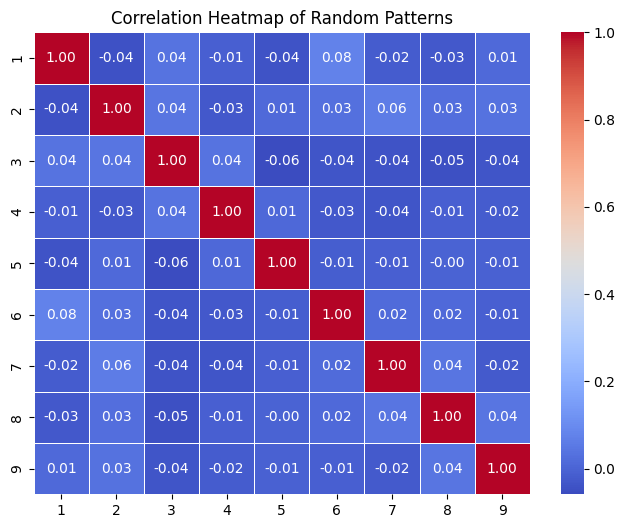

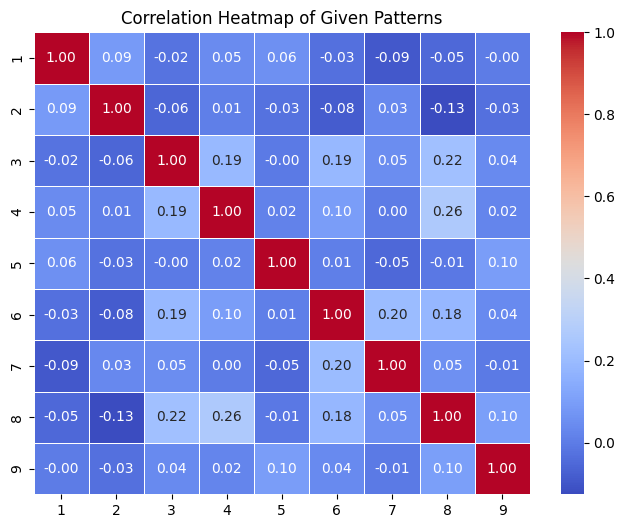

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

random_patterns_correlation = pd.DataFrame(random_patterns.T).corr()
patterns_correlation = pd.DataFrame(hn._load_pattern(None, [x for x in range(1,10)]).T).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(random_patterns_correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", xticklabels=range(1, 10), yticklabels=range(1, 10))
plt.title('Correlation Heatmap of Random Patterns')
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(patterns_correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", xticklabels=range(1, 10), yticklabels=range(1, 10))
plt.title('Correlation Heatmap of Given Patterns')
plt.show()

## 3.5.2 Stability Testing

### What happens with the number of stable patterns as more are learned?

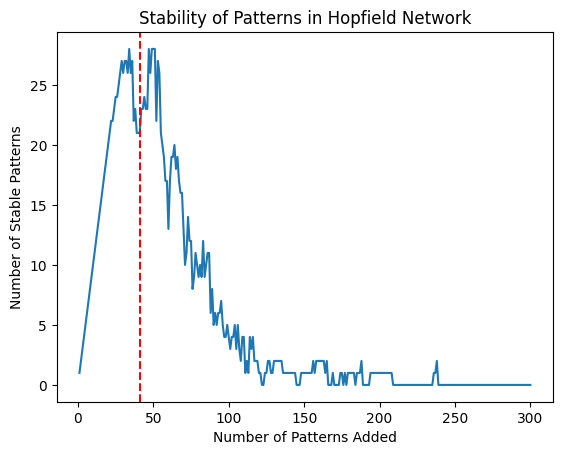

In [13]:
num_patterns=300
network_size=300
random_patterns = generate_random_patterns(num_patterns=num_patterns, pattern_size=network_size)
hn = HopfieldNetwork(n_nodes=network_size)
stable_counts = hn.fit_incremental(random_patterns)
capacity = 0.138 * network_size

# plt.scatter(range(1, num_patterns + 1), stable_counts, s=10, alpha=0.7, c='dodgerblue')
plt.plot(range(1, num_patterns + 1), stable_counts)
plt.axvline(x=capacity, color='red', linestyle='--', label=f'Capacity = {capacity}')

plt.xlabel("Number of Patterns Added")
plt.ylabel("Number of Stable Patterns")
plt.title("Stability of Patterns in Hopfield Network")

plt.show()

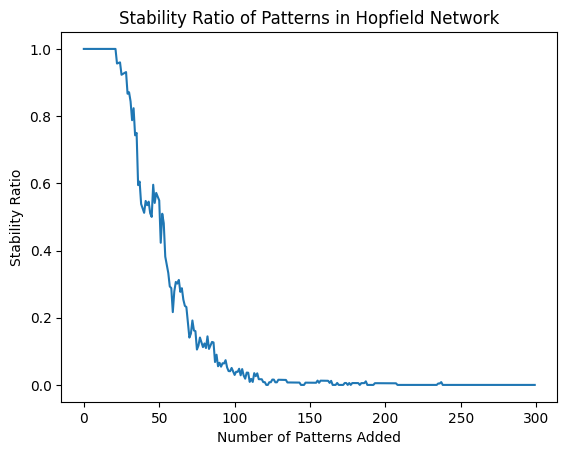

In [6]:
def divide_lists_elementwise(list1, list2):
    result = [a / b for a, b in zip(list1, list2)]
    return result

ratio = divide_lists_elementwise(stable_counts, range(1, num_patterns + 1))

plt.plot(ratio)

plt.xlabel("Number of Patterns Added")
plt.ylabel("Stability Ratio")
plt.title("Stability Ratio of Patterns in Hopfield Network")

plt.show()

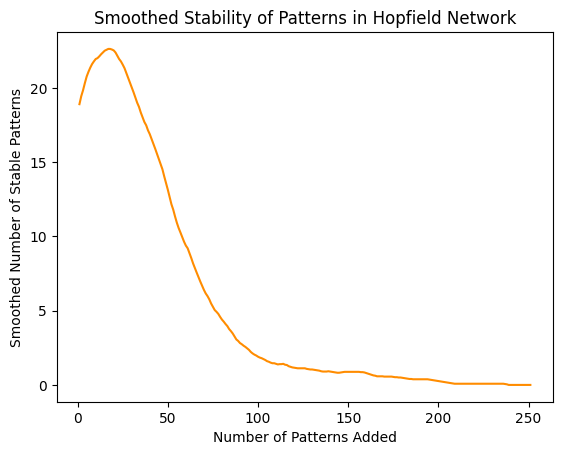

In [7]:
window_size = 50
smoothed_counts = np.convolve(stable_counts, np.ones(window_size)/window_size, mode='valid')

plt.plot(range(1, len(smoothed_counts) + 1), smoothed_counts, color='darkorange')
plt.xlabel("Number of Patterns Added")
plt.ylabel("Smoothed Number of Stable Patterns")
plt.title("Smoothed Stability of Patterns in Hopfield Network")
plt.show()

### What happens if convergence to the pattern from a noisy version (a few flipped units) is used? What does the different behavior for large number of patterns mean?

With a small number of stored patterns: The network should be able to recover the original pattern from a noisy version because Hopfield networks act as associative memories. As more patterns are stored: The network’s recall ability deteriorates. This means: Some noisy inputs may converge to the wrong pattern. Some may get stuck in spurious (incorrect but stable) states. Some may fail to converge at all (oscillations or chaotic behavior). For a large number of stored patterns (~0.15N or more): The network loses its ability to reliably recover original patterns from noise, leading to a significant drop in retrieval accuracy.

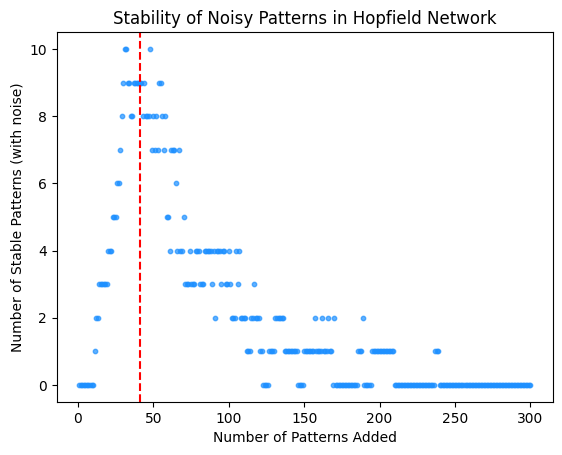

In [8]:
num_patterns=300
network_size=300
distorted_pixels=4
random_patterns = generate_random_patterns(num_patterns=num_patterns, pattern_size=network_size)
distorted_random_patterns = HopfieldNetwork(n_nodes=network_size).distort_patterns(
    num_units=distorted_pixels, patterns=random_patterns
)

correct_preds = []
for i in range(num_patterns):
    hn = HopfieldNetwork(n_nodes=network_size)
    hn.fit(patterns=random_patterns[:i])
    preds = hn.recall(distorted_random_patterns[:i])
    correct_preds.append(
        sum(
            hn.evaluate(patterns_pred=preds, patterns=distorted_random_patterns[:i])
        )
    )

plt.scatter(range(1, num_patterns+1), correct_preds, s=10, alpha=0.7, c='dodgerblue')
plt.axvline(x=0.138*network_size, color='red', linestyle='--', label=f'Capacity = {capacity}')
plt.xlabel("Number of Patterns Added")
plt.ylabel("Number of Stable Patterns (with noise)")
plt.title("Stability of Noisy Patterns in Hopfield Network")
plt.show()

## 3.5.3 Removing Self-Connections

### Header 3

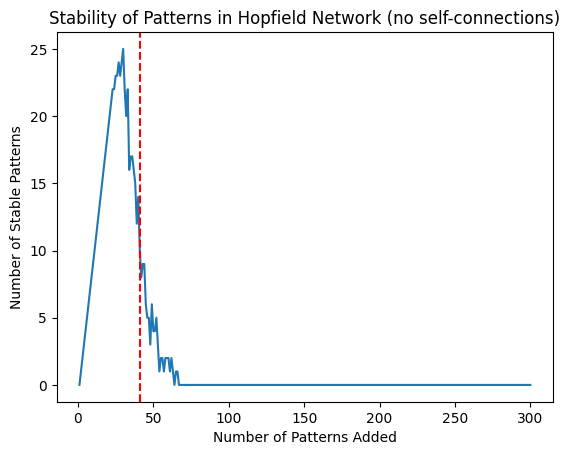

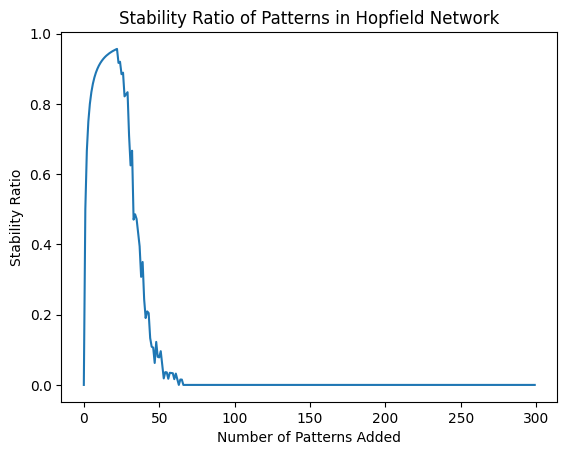

In [26]:
num_patterns=300
network_size=300
random_patterns = generate_random_patterns(num_patterns=num_patterns, pattern_size=network_size)
# hn = HopfieldNetwork(n_nodes=num_patterns, remove_self_connections=True)
# stable_counts = hn.fit_incremental(random_patterns)

# plt.scatter(range(1, num_patterns + 1), stable_counts, s=10, alpha=0.7, c='dodgerblue')
# plt.axvline(x=0.138*network_size, color='red', linestyle='--', label=f'Capacity = {capacity}')

# plt.xlabel("Number of Patterns Added")
# plt.ylabel("Number of Stable Patterns")
# plt.title("Stability of Patterns in Hopfield Network (no self-connections)")

# plt.show()

correct_preds = []
for i in range(num_patterns):
    _patterns = random_patterns[:i]
    hn = HopfieldNetwork(n_nodes=network_size, remove_self_connections=True)
    hn.fit(patterns=_patterns)
    preds = hn.recall(_patterns)
    correct_preds.append(
        sum(
            hn.evaluate(patterns_pred=preds, patterns=_patterns)
        )
    )

# plt.scatter(range(1, num_patterns+1), correct_preds, s=10, alpha=0.7, c='dodgerblue')
plt.plot(range(1, num_patterns+1), correct_preds)
plt.axvline(x=0.138*network_size, color='red', linestyle='--', label=f'Capacity = {capacity}')
plt.xlabel("Number of Patterns Added")
plt.ylabel("Number of Stable Patterns")
plt.title("Stability of Patterns in Hopfield Network (no self-connections)")
plt.show()

def divide_lists_elementwise(list1, list2):
    result = [a / b for a, b in zip(list1, list2)]
    return result

ratio = divide_lists_elementwise(correct_preds, range(1, num_patterns + 1))

plt.plot(ratio)

plt.xlabel("Number of Patterns Added")
plt.ylabel("Stability Ratio")
plt.title("Stability Ratio of Patterns in Hopfield Network")

plt.show()

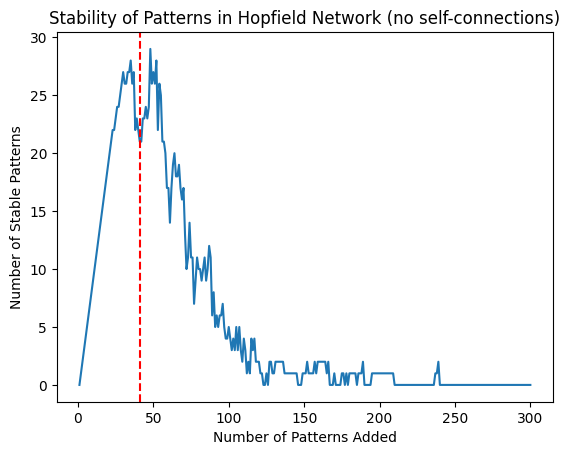

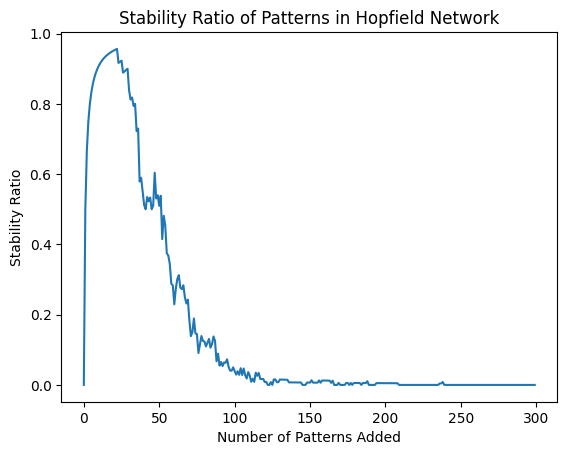

In [ ]:
num_patterns=300
network_size=300
random_patterns = generate_random_patterns(num_patterns=num_patterns, pattern_size=network_size)
# hn = HopfieldNetwork(n_nodes=num_patterns, remove_self_connections=True)
# stable_counts = hn.fit_incremental(random_patterns)

# plt.scatter(range(1, num_patterns + 1), stable_counts, s=10, alpha=0.7, c='dodgerblue')
# plt.axvline(x=0.138*network_size, color='red', linestyle='--', label=f'Capacity = {capacity}')

# plt.xlabel("Number of Patterns Added")
# plt.ylabel("Number of Stable Patterns")
# plt.title("Stability of Patterns in Hopfield Network (no self-connections)")

# plt.show()

correct_preds = []
for i in range(num_patterns):
    _patterns = random_patterns[:i]
    hn = HopfieldNetwork(n_nodes=network_size, remove_self_connections=False)
    hn.fit(patterns=_patterns)
    preds = hn.recall(_patterns)
    correct_preds.append(
        sum(
            hn.evaluate(patterns_pred=preds, patterns=_patterns)
        )
    )

# plt.scatter(range(1, num_patterns+1), correct_preds, s=10, alpha=0.7, c='dodgerblue')
plt.plot(range(1, num_patterns+1), correct_preds)
plt.axvline(x=0.138*network_size, color='red', linestyle='--', label=f'Capacity = {capacity}')
plt.xlabel("Number of Patterns Added")
plt.ylabel("Number of Stable Patterns")
plt.title("Stability of Patterns in Hopfield Network (no self-connections)")
plt.show()

def divide_lists_elementwise(list1, list2):
    result = [a / b for a, b in zip(list1, list2)]
    return result

ratio = divide_lists_elementwise(correct_preds, range(1, num_patterns + 1))

plt.plot(ratio)

plt.xlabel("Number of Patterns Added")
plt.ylabel("Stability Ratio")
plt.title("Stability Ratio of Patterns in Hopfield Network")

plt.show()

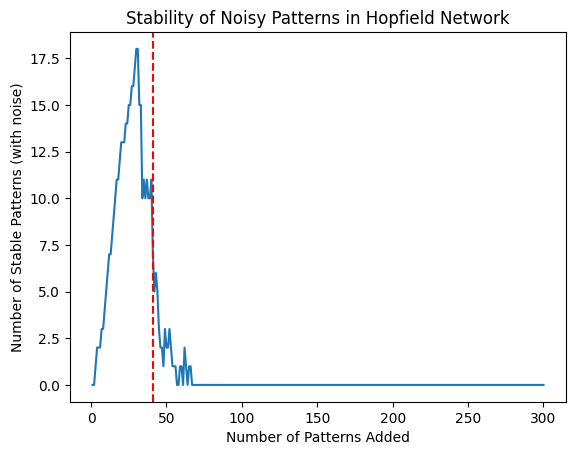

In [23]:
num_patterns=300
network_size=300
distorted_pixels=2
random_patterns = generate_random_patterns(num_patterns=num_patterns, pattern_size=network_size)
distorted_random_patterns = HopfieldNetwork(n_nodes=network_size).distort_patterns(
    num_units=distorted_pixels, patterns=random_patterns
)

correct_preds = []
for i in range(num_patterns):
    hn = HopfieldNetwork(n_nodes=network_size, remove_self_connections=True)
    hn.fit(patterns=random_patterns[:i])
    preds = hn.recall(distorted_random_patterns[:i])
    correct_preds.append(
        sum(
            hn.evaluate(patterns_pred=preds, patterns=distorted_random_patterns[:i])
        )
    )

# plt.scatter(range(1, num_patterns+1), correct_preds, s=10, alpha=0.7, c='dodgerblue')
plt.plot(range(1, num_patterns+1), correct_preds)

plt.axvline(x=0.138*network_size, color='red', linestyle='--', label=f'Capacity = {capacity}')
plt.xlabel("Number of Patterns Added")
plt.ylabel("Number of Stable Patterns (with noise)")
plt.title("Stability of Noisy Patterns in Hopfield Network")
plt.show()

### Header 3

### Header 3